# EfficientNetB0 Starter for Brain Competition
This notebook serves as a starting point for beginners like myself 😄, with no prior experience in computer vision or limited medical knowledge. While it doesn't aim to achieve high scores, it offers a gentle introduction to the field.

### What is an EEG waveform? 
EEG (electroencephalogram) waveform is a graphic visualization of brain activity. EEG is a machine that measures brain activity through electrical voltage. The EEG waveforms can be characterized by several key features:
- Frequency (Hertz): represents the number of cycles the wave completes in a second. Different brain states are associated with different frequency ranges.
- Amplitude: The height of the wave, indicating the strength of the electrical activity.
- Morphology: The shape of the wave, which can provide additional information about the underlying brain activity.

Here are some of the common types of EEG waveforms classified based on their frequency:
- Delta (0.5 - 4 Hz): Associated with deep sleep and unconsciousness.
- Theta (4 - 7 Hz): Associated with drowsiness, meditation, and daydreaming.
- Alpha (8 - 12 Hz): Associated with relaxation and alertness with eyes closed.
- Beta (13 - 30 Hz): Associated with active thinking, problem-solving, and focused attention.
- Gamma (30 - 80 Hz): Associated with high-level cognitive functions and information processing.

By analyzing these waveforms, healthcare professionals can understand brain function and identify potential abnormalities or conditions.

### What is spectrograms?

A spectrogram is like a "fingerprint" of a signal, showing how the strength of different frequencies changes over time. It's a visual representation of the signal's frequency content, helping us understand how the signal evolves with time. 

### Notebook implmentation
- **Training dataset**: The training dataset contains (1) Kaggle spectrograms and (2) additional raw EEG spectrograms from [brain-eeg-spectrograms dataset](https://www.kaggle.com/datasets/cdeotte/brain-eeg-spectrograms). Kaggle spectrograms are 10-minute visual representations of EEG signals, while raw EEG spectrograms are 50-second recordings capturing the same events.
- **Target**: Targets are the probabilities of 6 patterns for each single spectrograms. The patterns include 'seizure', 'lpd', 'gpd', 'lrda', 'grda' and 'other' 
- **EfficientNets**: This notebook builds `EfficientNets` model to capture spectrogram features and make the voting predictions of 6 patterns. Scaling CNNs traditionally involved tedious manual tuning due to inconsistent results. EfficientNet's compound scaling tackles this by uniformly scaling depth, width, and resolution together, eliminating the need for manual tuning. The torchvision library (part of PyTorch) is used to create the EfficientNetB0 model and leverage its pretrained weights. Paper:  [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)
- **Model Weight**: The trained model weights are stored in the [brain-eeg-spectrograms-data-weng dataset]: https://www.kaggle.com/datasets/minhsienweng/brain-eeg-spectrograms-data

### Change Logs
- (LB 0.34) Use an emsemble of 4 models 
    - Kaggle's spectrogram model
    - Kaggle + EEG spectrogram model
    - EEG spectrogram model
    - EEG's raw wavenet model
- [Version 22] (LB 0.4) Using Pytorch lightning to simplify the model training
- [Version 1] (LB 0.43) Trained an `EfficientNetB0` model using both Kaggle spectrograms and additional EEG spectrograms.

### References
This notebook is forked from
- @DANIAL ZAKARIA [Features+Head Starter](https://www.kaggle.com/code/nartaa/features-head-starter)
- [EfficientNetB0 Pytorch Starter - [LB 0.40]](https://www.kaggle.com/code/crackle/efficientnetb0-pytorch-starter-lb-0-40)
- [EfficientNetB0 Starter - [LB 0.43]](https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43)
- [HMS | EfficientNetB0 PyTorch [Train]](https://www.kaggle.com/code/alejopaullier/hms-efficientnetb0-pytorch-train)

In [ ]:
import shutil
# Copy pretrained model weights to working folder
# shutil.copy(f'/kaggle/input/brain-eeg-spectrograms-data/EffNet_v0_f0.ckpt', f'/kaggle/working/EffNet_v0_f0.ckpt')
shutil.copy(f'/kaggle/input/brain-eeg-spectrograms-data/efficientnet_b0_rwightman-7f5810bc.pth', f'/kaggle/working/efficientnet_b0_rwightman-7f5810bc.pth')

# Imports

In [ ]:
import os, gc, sys, time, math, torch
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold, GroupKFold
import tensorflow as tf
import tensorflow.keras.backend as K, gc
import matplotlib.pyplot as plt
print('TensorFlow version =',tf.__version__)
assert tf.__version__ == '2.13.0', 'Tensorflow Version should be 2.13.0'

In [ ]:
import random, torch
# Seed the same seed to all 
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

SEED = 42
seed_everything(SEED)

In [ ]:
import ctypes, gc
libc = ctypes.CDLL("libc.so.6")
# Clear unused memory (garbage collection)
def clear_memory():
    libc.malloc_trim(0)
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {DEVICE}")

## Distribution Computing
Specify computing devices and use mix-precisions if possible

In [ ]:
# Enable Distribution using multiple GPUs 
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) ==0:
    strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
    print("Using CPUs")
elif len(gpus)==1:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

# USE MIXED PRECISION
ENABLED = True
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

# Create Train Dataset

## Load Train Features
Create spectrogram features like`spectrogram_id` `eeg_id` `spectrogram_label_offset_seconds`...

The targets are six patterns: seizure (SZ), LPD (lateralized periodic discharges), GPD (generalized periodic discharges), LRDA (lateralized rhythmic delta activity), GRDA (generalized rhythmic delta activity), or “other”
[Relevant Discussion](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021)

In [ ]:
class CFG:
    batch_size = 4 
    shuffle = False
    TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    
# Create train features
'''we generate training data by averaging votes for each unique spectrogram_id in the training set
so the training dataset contains no samples with duplicate spectrogram_id values.'''
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
FEATS2 = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
FEAT2IDX = {x:y for x,y in zip(FEATS2,range(len(FEATS2)))}

def eeg_from_parquet(parquet_path):

    eeg = pd.read_parquet(parquet_path, columns=FEATS2)
    rows = len(eeg)
    offset = (rows-10_000)//2
    eeg = eeg.iloc[offset:offset+10_000]
    data = np.zeros((10_000,len(FEATS2)))
    for j,col in enumerate(FEATS2):
        
        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0
        
        data[:,j] = x

    return data

def add_kl(data):
    import torch
    labels = data[TARGETS].values + 1e-5

    # compute kl-loss with uniform distribution by pytorch
    data['kl'] = torch.nn.functional.kl_div(
        torch.log(torch.tensor(labels)),
        torch.tensor([1 / 6] * 6),
        reduction='none'
    ).sum(dim=1).numpy()
    return data

In [ ]:
train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
META = ['spectrogram_id','spectrogram_label_offset_seconds','patient_id','expert_consensus']
# Group by eeg_id and select the first one and sum up all the votes for eeg_id
train = train.groupby('eeg_id')[META+TARGETS].agg({**{m:'first' for m in META},**{t:'sum' for t in TARGETS}}).reset_index() 
# Add the TARGETS columns (probablities of each vote for a eeg_id)
train[TARGETS] = train[TARGETS]/train[TARGETS].values.sum(axis=1,keepdims=True)
train.columns = ['eeg_id','spec_id','offset','patient_id','target'] + TARGETS
train_df = add_kl(train)
display(train_df.head(10))

## Visualizing training features

In [ ]:
def plot_df(train_df):
    # print('Train shape:', train_df.shape)
    # print(f'Target columns: {CFG.TARGETS}')
    # Sum 
    train_df['total_evaluators'] = train_df[CFG.TARGETS].sum(axis=1) 
    train_df = train_df.sort_values('eeg_id', ascending=True)
    # print(f"Unique EEGIDs = {len(train_df['eeg_id'].unique())}")
    # print(f"Unique patients = {len(train_df['patient_id'].unique())}")
    plt_df = train_df[['eeg_id'] + list(CFG.TARGETS)]
    # Count the number of values >=1.0 in each target column
    results = [] 
    for target in CFG.TARGETS:
        results.append({'vote': target, 'counts': train_df[train_df[target] >= 1.0]['eeg_id'].count()})
    # print(results)
    # Plot the graph
    plt_df = pd.DataFrame(results)
    fig = plt.figure(figsize=(6,8))
    plt.scatter(x=plt_df['vote'], y=plt_df['counts'])
    # Customize axis labels
    plt.xlabel('vote')
    plt.ylabel('counts (%)')
    plt.show()

In [ ]:
DEBUG = False
if DEBUG:
    # Most of votes goes to 'other votes' followed by 'seisure' and 'lpd'
    plot_df(train_df)
    clear_memory()

## Load Kaggle Training Spectrograms 
The Kaggle training dataset comprises 11,000 individual spectrogram files. The single file specs.npy stores all the training spectrograms from the Kaggle competition. This file is loaded as a dictionary, where the key is the spectrogram_id and the value is a NumPy array with dimensions (300x400).

In [ ]:
def load_kaggle_training_specs():
    # Load all the spectrogram files in a single read (1 minutes)
    specs = np.load('/kaggle/input/brain-spectrograms/specs.npy', allow_pickle=True).item()
    spec_id = 1000086677
    print(specs[spec_id].shape)
    return specs

In [ ]:
specs = load_kaggle_training_specs()

## Load Additional EEG Spectrograms
The additional EEG spectrograms come from @DANIAL ZAKARIA's [eeg spectrograms](https://www.kaggle.com/datasets/nartaa/eeg-spectrograms). This file is loaded as a dictionary, where the key is the spectrogram_id and the value is a NumPy array with dimensions (100x300x4).

In [ ]:
def load_eeg_specs():
    eeg_specs = np.load('/kaggle/input/eeg-spectrograms/eeg_specs.npy', allow_pickle=True).item()
    spec_id = 1000913311
    print(eeg_specs[spec_id].shape)
    return eeg_specs

In [ ]:
eeg_specs = load_eeg_specs()

# Data Generator
This data generator outputs 512x512x3, the spectrogram and eeg images are concatenated all togother in a single image. For using data augmention you can set augment = True when creating the train data generator.

In [ ]:
# Albumentations is a computer vision tool (https://albumentations.ai/) that perform image augmentations
import albumentations as albu
# Create the dataset that includes the Kaggle and additional EEG spectrogram images 
import albumentations as albu
from scipy.signal import butter, lfilter

class DataGenerator():
    'Generates data for Keras'
    def __init__(self, data, specs=None, eeg_specs=None, raw_eegs=None, augment=False, 
                 mode='train', data_type='both'): 
        self.data = data
        self.augment = augment
        self.mode = mode
        self.data_type = data_type
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.raw_eegs = raw_eegs
        self.on_epoch_end()
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        X, y = self.data_generation(index)
        if self.augment: 
            X = self.augmentation(X)
        return X, y
    
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            
            if i == self.__len__()-1:
                self.on_epoch_end()
                
    def on_epoch_end(self):
        if self.mode=='train': 
            self.data = self.data.sample(frac=1).reset_index(drop=True)
    
    def data_generation(self, index):
        if self.data_type == 'both':
            X,y = self.generate_all_specs(index)
        elif self.data_type == 'eeg' or self.data_type == 'kaggle':
            X,y = self.generate_specs(index)
        elif self.data_type == 'raw':
            X,y = self.generate_raw(index)

        return X,y
    
    def generate_all_specs(self, index):
        X = np.zeros((512,512,3),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        if self.mode=='test': 
            offset = 0
        else:
            offset = int(row.offset/2)
            
        eeg = self.eeg_specs[row.eeg_id]
        spec = self.specs[row.spec_id]
        
        imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in [0,2,1,3]] # to match kaggle with eeg
        img = np.stack(imgs,axis=-1)
        # LOG TRANSFORM SPECTROGRAM
        img = np.clip(img,np.exp(-4),np.exp(8))
        img = np.log(img)
            
        # STANDARDIZE PER IMAGE
        img = np.nan_to_num(img, nan=0.0)    
            
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        
        X[0_0+56:100+56,:256,0] = img[:,22:-22,0] # LL_k
        X[100+56:200+56,:256,0] = img[:,22:-22,2] # RL_k
        X[0_0+56:100+56,:256,1] = img[:,22:-22,1] # LP_k
        X[100+56:200+56,:256,1] = img[:,22:-22,3] # RP_k
        X[0_0+56:100+56,:256,2] = img[:,22:-22,2] # RL_k
        X[100+56:200+56,:256,2] = img[:,22:-22,1] # LP_k
        
        X[0_0+56:100+56,256:,0] = img[:,22:-22,0] # LL_k
        X[100+56:200+56,256:,0] = img[:,22:-22,2] # RL_k
        X[0_0+56:100+56,256:,1] = img[:,22:-22,1] # LP_k
        X[100+56:200+56,256:,1] = img[:,22:-22,3] # RP_K
        
        # EEG
        img = eeg
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        X[200+56:300+56,:256,0] = img[:,22:-22,0] # LL_e
        X[300+56:400+56,:256,0] = img[:,22:-22,2] # RL_e
        X[200+56:300+56,:256,1] = img[:,22:-22,1] # LP_e
        X[300+56:400+56,:256,1] = img[:,22:-22,3] # RP_e
        X[200+56:300+56,:256,2] = img[:,22:-22,2] # RL_e
        X[300+56:400+56,:256,2] = img[:,22:-22,1] # LP_e
        
        X[200+56:300+56,256:,0] = img[:,22:-22,0] # LL_e
        X[300+56:400+56,256:,0] = img[:,22:-22,2] # RL_e
        X[200+56:300+56,256:,1] = img[:,22:-22,1] # LP_e
        X[300+56:400+56,256:,1] = img[:,22:-22,3] # RP_e

        if self.mode!='test':
            y[:] = row[TARGETS]
        
        return X,y
    
    def generate_specs(self, index):
        X = np.zeros((512,512,3),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        if self.mode=='test': 
            offset = 0
        else:
            offset = int(row.offset/2)
            
        if self.data_type == 'eeg':
            img = self.eeg_specs[row.eeg_id]
        elif self.data_type == 'kaggle':
            spec = self.specs[row.spec_id]
            imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in [0,2,1,3]] # to match kaggle with eeg
            img = np.stack(imgs,axis=-1)
            # LOG TRANSFORM SPECTROGRAM
            img = np.clip(img,np.exp(-4),np.exp(8))
            img = np.log(img)
            
            # STANDARDIZE PER IMAGE
            img = np.nan_to_num(img, nan=0.0)    
            
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        
        X[0_0+56:100+56,:256,0] = img[:,22:-22,0]
        X[100+56:200+56,:256,0] = img[:,22:-22,2]
        X[0_0+56:100+56,:256,1] = img[:,22:-22,1]
        X[100+56:200+56,:256,1] = img[:,22:-22,3]
        X[0_0+56:100+56,:256,2] = img[:,22:-22,2]
        X[100+56:200+56,:256,2] = img[:,22:-22,1]
        
        X[0_0+56:100+56,256:,0] = img[:,22:-22,0]
        X[100+56:200+56,256:,0] = img[:,22:-22,1]
        X[0_0+56:100+56,256:,1] = img[:,22:-22,2]
        X[100+56:200+56,256:,1] = img[:,22:-22,3]
        
        X[200+56:300+56,:256,0] = img[:,22:-22,0]
        X[300+56:400+56,:256,0] = img[:,22:-22,1]
        X[200+56:300+56,:256,1] = img[:,22:-22,2]
        X[300+56:400+56,:256,1] = img[:,22:-22,3]
        X[200+56:300+56,:256,2] = img[:,22:-22,3]
        X[300+56:400+56,:256,2] = img[:,22:-22,2]
        
        X[200+56:300+56,256:,0] = img[:,22:-22,0]
        X[300+56:400+56,256:,0] = img[:,22:-22,2]
        X[200+56:300+56,256:,1] = img[:,22:-22,1]
        X[300+56:400+56,256:,1] = img[:,22:-22,3]
        
        if self.mode!='test':
            y[:] = row[TARGETS]
        
        return X,y
    
    def generate_raw(self,index):
        X = np.zeros((10_000,8),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        eeg = self.raw_eegs[row.eeg_id]
            
        # FEATURE ENGINEER
        X[:,0] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['T3']]
        X[:,1] = eeg[:,FEAT2IDX['T3']] - eeg[:,FEAT2IDX['O1']]
            
        X[:,2] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['C3']]
        X[:,3] = eeg[:,FEAT2IDX['C3']] - eeg[:,FEAT2IDX['O1']]
            
        X[:,4] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['C4']]
        X[:,5] = eeg[:,FEAT2IDX['C4']] - eeg[:,FEAT2IDX['O2']]
            
        X[:,6] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['T4']]
        X[:,7] = eeg[:,FEAT2IDX['T4']] - eeg[:,FEAT2IDX['O2']]
            
        # STANDARDIZE
        X = np.clip(X,-1024,1024)
        X = np.nan_to_num(X, nan=0) / 32.0
            
        # BUTTER LOW-PASS FILTER
        X = self.butter_lowpass_filter(X)
        # Downsample
        X = X[::5,:]
        
        if self.mode!='test':
            y[:] = row[TARGETS]
                
        return X,y
        
    def butter_lowpass_filter(self, data, cutoff_freq=20, sampling_rate=200, order=4):
        nyquist = 0.5 * sampling_rate
        normal_cutoff = cutoff_freq / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        filtered_data = lfilter(b, a, data, axis=0)
        return filtered_data
    
    def resize(self, img,size):
        composition = albu.Compose([
                albu.Resize(size[0],size[1])
            ])
        return composition(image=img)['image']
            
    def augmentation(self, img):
        composition = albu.Compose([
                albu.HorizontalFlip(p=0.4)
            ])
        return composition(image=img)['image']

## Visualize the training dataset (spectrograms)
Here are sample results from data loader's images
- EEG ID = 568657
Target= 0.00, 0.00, 0.25, 0.00, 0.17, 0.58
- EEG ID = 582999
Target = 0.00, 0.86, 0.00, 0.07, 0.00, 0.07
- EEG ID = 642382
Target = 0.00, 0.00, 0.00, 0.00, 0.00, 1.00
- EEG ID = 751790
Target= 0.00, 0.00, 1.00, 0.00, 0.00, 0.00
- EEG ID = 778705
Target= 0.00, 0.00, 0.00, 0.00, 0.00, 1.00
- EEG ID = 1629671
Target 1.00, 0.00, 0.00, 0.00, 0.00, 0.00

<div>
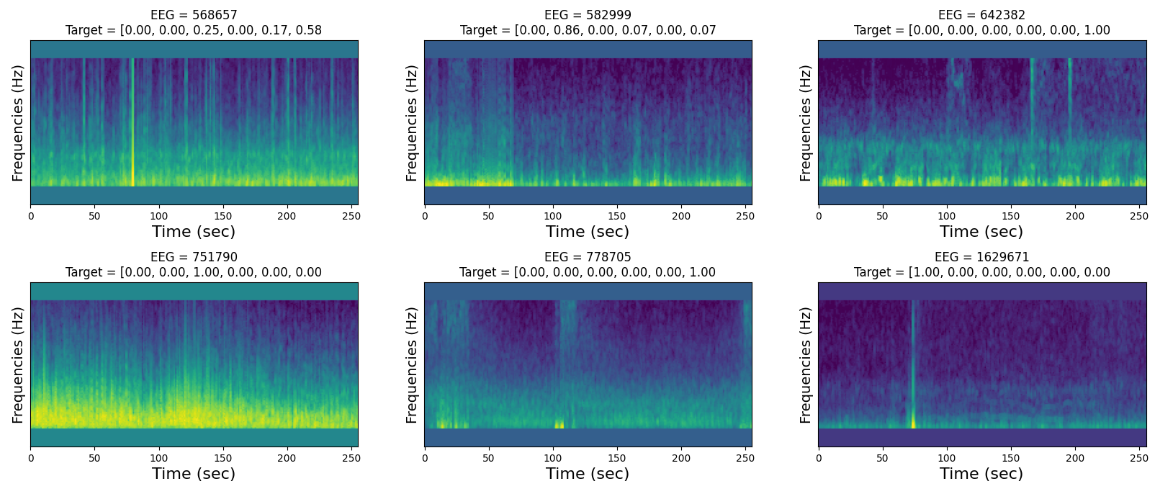
</div>

In [ ]:
def display_data_gen(data_gen, train_df):
    eeg_ids = train_df['eeg_id'].values
    # Batch
    for x,y in data_gen:
        break
    plt.imshow(x[:,:,0])
    plt.title(f'Target = {y.round(1)}',size=12)
    plt.yticks([])
    plt.ylabel('Frequencies (Hz)',size=12)
    plt.xlabel('Time (sec)',size=12)
    plt.show()

In [ ]:
DEBUG = False
if DEBUG:
    # Create the dataset
    data_gen = DataGenerator(train_df, specs, eeg_specs)
    # Create the dataloader from the dataset
    display_data_gen(data_gen, train_df) # display the dataset for verification
    del data_gen
    clear_memory()

# Train Model
We train using Group KFold on patient id. If `LOAD_MODELS_FROM = None`, then we will train new models in this notebook version. Otherwise we will load saved models from the path `LOAD_MODELS_FROM`.

## Train EfficientNet Model
The notebook uses `PyTorch Lightning` to create and train the EfficientNetB0 model using both Kaggle spectrograms and EEG spectrograms from our data loader.

In [ ]:
# Create learning rate
def lrfn(epoch):
    e3 = 1e-3 if DATA_TYPE in ['R'] else 1e-4
    return [1e-3,1e-3,e3,1e-4,1e-5][epoch]

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

def lrfn2(epoch):
    return [1e-5,1e-5,1e-6][epoch]

LR2 = tf.keras.callbacks.LearningRateScheduler(lrfn2, verbose = True)

## Create the Model

In [ ]:
from tensorflow.keras.layers import Input, Dense, Multiply, Add, Conv1D, Concatenate, LayerNormalization


def build_model():
    K.clear_session()
    with strategy.scope():
        if DATA_TYPE in ['R']:
            model = build_wave_model()
        elif DATA_TYPE in ['K','E','KE']:
            model = build_spec_model()
        elif DATA_TYPE in ['KR','ER','KER']:
            model = build_hybrid_model()
    return model

def build_spec_model(hybrid=False):  
    inp = tf.keras.layers.Input((512,512,3))
    base_model = load_model(f'{LOAD_BACKBONE_FROM}')    
    x = base_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if not hybrid:
        x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer=opt)  
    return model

def wave_block(x, filters, kernel_size, n):
    dilation_rates = [2**i for i in range(n)]
    x = Conv1D(filters = filters,
               kernel_size = 1,
               padding = 'same')(x)
    res_x = x
    for dilation_rate in dilation_rates:
        tanh_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same', 
                          activation = 'tanh', 
                          dilation_rate = dilation_rate)(x)
        sigm_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation = 'sigmoid', 
                          dilation_rate = dilation_rate)(x)
        x = Multiply()([tanh_out, sigm_out])
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = Add()([res_x, x])
    return res_x

def build_wave_model(hybrid=False):
        
    # INPUT 
    inp = tf.keras.Input(shape=(2_000,8))
    
    ############
    # FEATURE EXTRACTION SUB MODEL
    inp2 = tf.keras.Input(shape=(2_000,1))
    x = wave_block(inp2, 8, 4, 6)
    x = wave_block(x, 16, 4, 6)
    x = wave_block(x, 32, 4, 6)
    x = wave_block(x, 64, 4, 6)
    model2 = tf.keras.Model(inputs=inp2, outputs=x)
    ###########
    
    # LEFT TEMPORAL CHAIN
    x1 = model2(inp[:,:,0:1])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,1:2])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z1 = tf.keras.layers.Average()([x1,x2])
    
    # LEFT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,2:3])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,3:4])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z2 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,4:5])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,5:6])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z3 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT TEMPORAL CHAIN
    x1 = model2(inp[:,:,6:7])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,7:8])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z4 = tf.keras.layers.Average()([x1,x2])
    
    # COMBINE CHAINS
    y = tf.keras.layers.Concatenate()([z1,z2,z3,z4])
    if not hybrid:
        y = tf.keras.layers.Dense(64, activation='relu')(y)
        y = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(y)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=y)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)
    
    return model

def build_hybrid_model():
    model_spec = build_spec_model(True)
    model_wave = build_wave_model(True)
    inputs = [model_spec.input, model_wave.input]
    x = [model_spec.output, model_wave.output]
    x = tf.keras.layers.Concatenate()(x)
    x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inputs, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)
    
    return model

def score(y_true, y_pred):
    kl = tf.keras.metrics.KLDivergence()
    return kl(y_true, y_pred)

def plot_hist(hist):
    metrics = ['loss']
    for i,metric in enumerate(metrics):
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,i+1)
        plt.plot(hist[metric])
        plt.plot(hist[f'val_{metric}'])
        plt.title(f'{metric}',size=12)
        plt.ylabel(f'{metric}',size=12)
        plt.xlabel('epoch',size=12)
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()
        
def dataset(data, mode='train', batch_size=8, data_type=DATA_TYPE, 
            augment=False, specs=None, eeg_specs=None, raw_eegs=None):
    
    BATCH_SIZE_PER_REPLICA = batch_size
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    gen = DataGenerator(data,mode=mode, data_type=data_type, augment=augment,
                       specs=specs, eeg_specs=eeg_specs, raw_eegs=raw_eegs)
    if data_type in ['K','E','KE']: 
        inp = tf.TensorSpec(shape=(512,512,3), dtype=tf.float32)
    elif data_type in ['KR','ER','KER']:
        inp = (tf.TensorSpec(shape=(512,512,3), dtype=tf.float32),tf.TensorSpec(shape=(2000,8), dtype=tf.float32))
    elif data_type in ['R']:
        inp = tf.TensorSpec(shape=(2000,8), dtype=tf.float32)
        
    output_signature = (inp,tf.TensorSpec(shape=(6,), dtype=tf.float32))
    dataset = tf.data.Dataset.from_generator(generator=gen, output_signature=output_signature).batch(
        BATCH_SIZE)
    return dataset

def reset_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

## Train and validate the model

In [ ]:
from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc
TRAINING = False
if TRAINING:
    reset_seed(42)
    all_oof = []
    all_true = []
    losses = []
    val_losses = []
    total_hist = {}

    gkf = GroupKFold(n_splits=5)
    for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):   
        print('#'*25)
        print(f'### Fold {i+1}')
        
        EPOCHS = 5
        params = {'specs':spectrograms, 'eeg_specs':all_eegs, 'raw_eegs':all_raw_eegs}
        data, val = train.iloc[train_index],train.iloc[valid_index]
        train_dataset = dataset(data, **params)
        val_dataset = dataset(val,mode='valid', **params)
        data = data[data['kl']<5.5]
        train_dataset2 = dataset(data, **params)
        
        print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
        print('#'*25)
        model = build_model()
        hist = model.fit(train_dataset, validation_data = val_dataset, 
                         epochs=EPOCHS, callbacks=[LR])
        print(f'### seconds stage train size {len(data)}, valid size {len(val)}')
        print('#'*25)
        hist2 = model.fit(train_dataset2, validation_data = val_dataset, 
                         epochs=3, callbacks=[LR2])
        losses.append(hist.history['loss']+hist2.history['loss'])
        val_losses.append(hist.history['val_loss']+hist2.history['val_loss'])
        with strategy.scope():
            model.save_weights(f'model_{DATA_TYPE}_{VER}_{i}.weights.h5')
        oof = model.predict(val_dataset, verbose=1)
        all_oof.append(oof)
        all_true.append(train.iloc[valid_index][TARGETS].values)    
        del model, oof
        gc.collect()
        
    total_hist['loss'] = np.mean(losses,axis=0)
    total_hist['val_loss'] = np.mean(val_losses,axis=0)
    all_oof = np.concatenate(all_oof)
    all_true = np.concatenate(all_true)
    plot_hist(total_hist)
    print('#'*25)
    print(f'CV KL SCORE: {score(all_true,all_oof)}')

In [ ]:
TRAINING = False
if TRAINING:
    # Train the model
    fold_indexes = []
    # GroupKFold split into 5 fold of training and valid dataset
    gkf = GroupKFold(n_splits=5)
    # Group the data using patient_id and split into `train` and `valid`
    for fold, (train_index, valid_index) in enumerate(gkf.split(train_df, train_df.target, 
                                                            train_df.patient_id)):
        print(f'### Fold {fold}  ###')
        train_data = train_df.iloc[train_index]
        valid_data = train_df.iloc[valid_index]
        print(f'### Train size: {len(train_data)}'
              f'### Valid size: {len(valid_data)}')
        train_model_by_fold(train_data, fold)
    # valid_model()
    sys.exit(0)

In [ ]:
del specs, eeg_specs
clear_memory()

# Model Inference
Use 5-fold CV EfficientNetB0 models to infer the test data and create a `submission.csv` file.

The trained EfficientNetB0 models are stored in `/kaggle/input/brain-eeg-spectrograms-models`.

## Load testing data

In [ ]:
import pywt, librosa

USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

import librosa

def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((100,300,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
            # FILL NANS
            x1 = eeg[COLS[kk]].values
            x2 = eeg[COLS[kk+1]].values
            m = np.nanmean(x1)
            if np.isnan(x1).mean()<1: x1 = np.nan_to_num(x1,nan=m)
            else: x1[:] = 0
            m = np.nanmean(x2)
            if np.isnan(x2).mean()<1: x2 = np.nan_to_num(x2,nan=m)
            else: x2[:] = 0
                
            # COMPUTE PAIR DIFFERENCES
            x = x1 - x2

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//300, 
                  n_fft=1024, n_mels=100, fmin=0, fmax=20, win_length=128)
            
            # LOG TRANSFORM
            width = (mel_spec.shape[1]//30)*30
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.show()
        
    return img

In [ ]:
# Load testing features
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
# RENAME FOR DATALOADER
test = test.rename({'spectrogram_id':'spec_id'}, axis=1)
print('Test shape', test.shape)
test.head()

In [ ]:
# Read the testing spectrograms 
folder = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
specs_files = os.listdir(folder)
print(f'There are {len(specs_files)} test spectrogram parquets')
# Store as a dictionary (Key: SpecID, Value: spectrogram values)
specs = {}
for i, spec_file in tqdm(enumerate(specs_files)):
    par_file_path = os.path.join(folder, spec_file)
    parquet = pd.read_parquet(f'{par_file_path}')
    spec_id = int(spec_file.split('.')[0]) # Get the spectrogram id from file name
    specs[spec_id] = parquet.iloc[:, 1:].values # Store spectrograms 

In [ ]:
# Read all EEG spectrograms
folder = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
eeg_ids = test['eeg_id'].unique() # Get all eeg_ids
eeg_specs = {}
print('Converting raw EEG to Spectrograms...')
for i, eeg_id in tqdm(enumerate(eeg_ids)):
    eeg_file_path = os.path.join(folder, f'{eeg_id}.parquet')
    # Create spectrogram FROM eegs parquet
    img = spectrogram_from_eeg(f'{eeg_file_path}', display=False)
    eeg_specs[eeg_id] = img
print(f"Finished reading the spectrograms from all eggs")

In [ ]:
# Read all raw EEG data 
raw_eegs = {}
eeg_ids = test['eeg_id'].unique()
path = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'

print('Processing Test EEG parquets...')
for i,eeg_id in enumerate(eeg_ids):
    # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
    data = eeg_from_parquet(f'{path}{eeg_id}.parquet')
    raw_eegs[eeg_id] = data
print(f'Finished reading all the raw eggs')

## Create testing datasets

In [ ]:
import tensorflow as tf
# Load Kaggle testing dataset
gen = DataGenerator(test, mode='test', data_type='kaggle', 
                    specs=specs, eeg_specs=eeg_specs)
test_dataset_kaggle = tf.data.Dataset.from_generator(
                        generator=gen, 
                        output_signature=(tf.TensorSpec(shape=(512,512,3), dtype=tf.float32),
                                          tf.TensorSpec(shape=(6,), dtype=tf.float32))
                      ).batch(64).prefetch(tf.data.AUTOTUNE)
print(f'test_dataset_kaggle = {test_dataset_kaggle}')
# Both kaggle and additional testing data
gen = DataGenerator(test, mode='test', data_type='both', 
                    specs=specs, eeg_specs=eeg_specs)
test_dataset_both = tf.data.Dataset.from_generator(
                        generator=gen, 
                        output_signature=(tf.TensorSpec(shape=(512,512,3), dtype=tf.float32),
                                          tf.TensorSpec(shape=(6,), dtype=tf.float32))
                    ).batch(64).prefetch(tf.data.AUTOTUNE)
print(f'test_dataset_both = {test_dataset_both}')
# EEG testing data
gen = DataGenerator(test, mode='test', data_type='eeg',
                    specs=specs, eeg_specs=eeg_specs)
test_dataset_eeg = tf.data.Dataset.from_generator(
                    generator=gen, 
                    output_signature=(tf.TensorSpec(shape=(512,512,3), dtype=tf.float32),
                                      tf.TensorSpec(shape=(6,), dtype=tf.float32))
                    ).batch(64).prefetch(tf.data.AUTOTUNE)
print(f'test_dataset_eeg = {test_dataset_eeg}')


# Raw EEG testing data
gen = DataGenerator(test, mode='test', data_type='raw',
                    raw_eegs=raw_eegs)
test_dataset_raw = tf.data.Dataset.from_generator(
                    generator=gen, 
                    output_signature=(tf.TensorSpec(shape=(2000,8), dtype=tf.float32),
                                      tf.TensorSpec(shape=(6,), dtype=tf.float32))
                    ).batch(64).prefetch(tf.data.AUTOTUNE)
print(f'test_dataset_raw = {test_dataset_raw}')

## Prediction with an ensemble of models
- Kaggle's spectrogram model
- Kaggle + EEG spectrogram model
- EEG spectrogram model
- EEG's raw wavenet model

In [ ]:
model_path = '/kaggle/input/features-head-starter-models/'
VERK = 43 # Kaggle's spectrogram model version
VERB = 47 # Kaggle's and EEG's spectrogram model version
VERE = 42 # EEG's spectrogram model version
VERR = 37 # EEG's raw wavenet model version, trained on single GPU
# LB SCORE FOR EACH MODEL
LBs = [0.37, 0.39, 0.41, 0.41] # Model weights 

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Multiply, Add, Conv1D, Concatenate
def build_model():  
    backbone_path = '/kaggle/input/efficientnetb-tf-keras/EfficientNetB2.h5'
    inp = tf.keras.layers.Input((512,512,3))
    base_model = load_model(f'{backbone_path}')    
    x = base_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
    model = tf.keras.Model(inputs=inp, outputs=output)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer=opt)  
    return model

def wave_block(x, filters, kernel_size, n):
    dilation_rates = [2**i for i in range(n)]
    x = Conv1D(filters = filters,
               kernel_size = 1,
               padding = 'same')(x)
    res_x = x
    for dilation_rate in dilation_rates:
        tanh_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same', 
                          activation = 'tanh', 
                          dilation_rate = dilation_rate)(x)
        sigm_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation = 'sigmoid', 
                          dilation_rate = dilation_rate)(x)
        x = Multiply()([tanh_out, sigm_out])
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = Add()([res_x, x])
    return res_x

def build_wave_model():        
    # INPUT 
    inp = tf.keras.Input(shape=(2_000,8))
    
    ############
    # FEATURE EXTRACTION SUB MODEL
    inp2 = tf.keras.Input(shape=(2_000,1))
    x = wave_block(inp2, 8, 4, 6)
    x = wave_block(x, 16, 4, 6)
    x = wave_block(x, 32, 4, 6)
    x = wave_block(x, 64, 4, 6)
    model2 = tf.keras.Model(inputs=inp2, outputs=x)
    ###########
    
    # LEFT TEMPORAL CHAIN
    x1 = model2(inp[:,:,0:1])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,1:2])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z1 = tf.keras.layers.Average()([x1,x2])
    
    # LEFT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,2:3])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,3:4])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z2 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,4:5])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,5:6])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z3 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT TEMPORAL CHAIN
    x1 = model2(inp[:,:,6:7])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,7:8])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z4 = tf.keras.layers.Average()([x1,x2])
    
    # COMBINE CHAINS
    y = tf.keras.layers.Concatenate()([z1,z2,z3,z4])
    y = tf.keras.layers.Dense(64, activation='relu')(y)
    y = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(y)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=y)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)
    
    return model

In [ ]:
preds = []
lbs = 1 - np.array(LBs)
weights = lbs/lbs.sum()
model = build_model()
model_wave = build_wave_model()

for i in range(5):
    print(f'Fold {i+1}')
    # Kaggle 
    model.load_weights(f'{model_path}model_kaggle_{VERK}_{i}.weights.h5')
    pred_kaggle = model.predict(test_dataset_kaggle, verbose=1)
    print(f"Complete model_kaggle_{VERK}_{i}.weights.h5")

    model.load_weights(f'{model_path}model_both_{VERB}_{i}.weights.h5')
    pred_both = model.predict(test_dataset_both, verbose=1)
    print(f"Complete model_both_{VERB}_{i}.weights.h5")

    model.load_weights(f'{model_path}model_eeg_{VERE}_{i}.weights.h5')
    pred_eeg = model.predict(test_dataset_eeg, verbose=1)
    print(f"Complete model_eeg_{VERE}_{i}.weights.h5")
    
    model_wave.load_weights(f'{model_path}model_raw_{VERR}_{i}.weights.h5')
    pred_raw = model_wave.predict(test_dataset_raw, verbose=1)
    print(f"Complete model_raw_{VERR}_{i}.weights.h5")
    
    pred = np.array([pred_both,pred_eeg,pred_kaggle,pred_raw])
    pred = np.average(pred,axis=0,weights=weights)
    preds.append(pred)
    del pred_kaggle, pred_both, pred_eeg, pred_raw
    clear_memory()

pred = np.mean(preds,axis=0)
print('Test preds shape',pred.shape)

In [ ]:
# INFER EFFICIENTNET ON TEST
def infer():
    preds = []
    test_ds = EEGDataset(test_df, mode='test', specs=test_specs, eeg_specs=test_eeg_specs)
    test_loader = DataLoader(test_ds, shuffle=False, batch_size=64, num_workers=3)
    FOLDS = 5
    for fold in range(FOLDS):
        try:
            print(f'### Testing Fold {fold}')
            model = EEGEffnetB0.load_from_checkpoint(f'EffNet_f{fold}.ckpt')
            model.to(DEVICE).eval()
            fold_preds = []
            # Enable inference mode
            with torch.inference_mode():
                for test_batch in test_loader:
                    test_batch = test_batch.to(DEVICE)
                    pred = torch.softmax(model(test_batch), dim=1).cpu().numpy()
                    fold_preds.append(pred)
                fold_preds = np.concatenate(fold_preds)
                preds.append(fold_preds)
            del model
            clear_memory()
        except Exception as e:
            print(f"Error occurs in fold {fold}. Error = {e}")
    # Average the predictions of all folds
    avg_preds = np.mean(preds, axis=0)
    del test_ds, test_loader
    clear_memory()
    print(f'Test avg preds = {avg_preds}')
    return avg_preds
avg_preds = infer()

In [ ]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[CFG.TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submissionn shape',sub.shape)
print()
print(sub.head().to_string())